# Chapter 6 게이트가 추가된 RNN

기본 RNN은 시간적으로 멀리 떨어진 장기 의존 관계를 잘 학습하기 어려워서 성능이 좋지 못하다.

LSTM과 GRU는 게이트(gate)라는 구조가 더해져 장기 의존 관계 또한 학습할 수 있다.

## 6.1 RNN의 문제점

문제: 장기 의존 관계를 학습하기 어렵다.  
원인: 기울기 소실 또는 기울기 폭발 발생

### 6.1.1 RNN 복습

바로 이전 시각의 은닉 상태를 이용해서 과거 정보를 기억 계승할 수 있다.

### 6.1.2 기울기 소실 또는 기울기 폭발

RNN 계층에서 과거 방향으로 의미 있는 기울기를 전달해서 장기 의존 관계를 학습해야 한다. 하지만 중간에 기울기가 사라지면 의미 있는 정보는 사라지게 되고 장기 의존 관계를 학습할 수 없게 된다. 단순한 RNN 계층에서는 기울기 소실 또는 기울기 폭발로 대부분 이어진다.

### 6.1.3 기울기 소실과 기울기 폭발의 원인

+의 역전파는 상류의 기울기를 단순히 하류로 보낼 뿐이므로 tanh와 MatMul에서 기울기 변화를 봐야 한다.

#### tanh

<img src="./images/fig 6-6.png" width=600>

tanh 노드를 지날 때마다 기울기 값은 계속 작아진다. RNN 계층의 활성화 함수로 tanh를 주로 사용하는데 ReLU로 바꾸면 기울기 소실을 줄일 수 있다.

#### MatMul(tanh는 무시하면)

<img src="./images/fig 6-7.png" width=600>

매번 똑같은 $W_h$가 행렬 곱셈에서 사용된다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)   # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

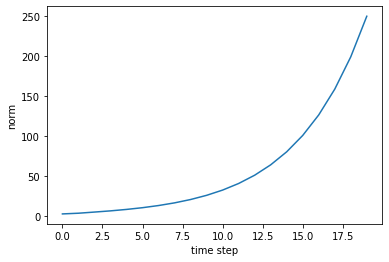

In [4]:
plt.plot(range(len(norm_list)), norm_list)
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

**기울기 폭발(exploding gradients)** 발생, 기울기 폭발이 발생하면 오버플로를 일으켜 NaN 값이 발생해서 제대로된 학습이 불가능하다.

In [5]:
N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3)   # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H) * 0.5  # 분포 변경

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

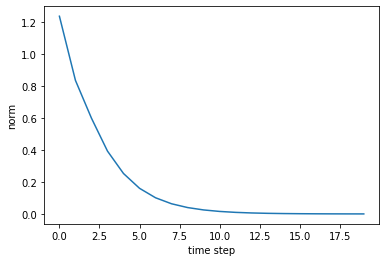

In [6]:
plt.plot(range(len(norm_list)), norm_list)
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

**기울기 손실** 발생, 기울기가 일정 수준 이하로 감소하면 더이상 갱신이 일어나지 않아서 장기 의존 관계를 학습할 수 없다. 

행렬의 경우에는 특잇값의 최댓값이 1보다 크면 지수적으로 증가하고, 1보다 작으면 지수적으로 감소할 가능성이 크다.

### 6.1.4 기울기 폭발 대책

#### 기울기 클리핑(gradients clipping)

기울기 폭발의 대책

<img src="./images/e 6-0.png" width=200>

In [8]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad += rate

## 6.2 기울기 소실과 LSTM

### 6.2.1 LSTM의 인터페이스

<img src="./images/fig 6-11.png" width=800>

**c: 기억 셀(memory cell)**이 추가되었다. 기억 셀은 LSTM 계층 내에서만 데이터를 주고 받는다. 출력으로 받는 쪽은 은닉 상태 h 뿐이므로 c를 생각할 필요가 없다.

### 6.2.2 LSTM 계층 조립하기

기억 셀 $c_t$에는 과거로부터 시각 $t$까지에 필요한 모든 정보가 저장돼 있다고 가정한다. 이 기억 셀을 바탕으로 외부 계층과 다음 시각의 LSTM에 은닉 상태 $h_t$를 출력한다.

기억 셀 $c_t$는 3개의 입력($c_{t-1}, h{t-1}, x_t$)의 계산을 통해 얻어진다. $h_t = tanh(c_t)$이다. $h_t$를 계산할 때 갱신된 기억 셀을 이용한다는 점을 주의해야 한다.

게이트는 흐름을 제어하는 역할을 한다. 게이트의 열림 상태는 0.0~1.0 사이의 실수로 나타내고, 이 값도 데이터로부터 자동으로 학습한다. 게이트의 열림 상태를 학습할 땐 시그모이드 함수를 이용한다.

### 6.2.3 output 게이트

output 게이트는 $tanh(c_t)$의 각 원소에 대해 다음 시각의 은닉 상태에 얼마나 중요한가를 조정한다.

output 게이트의 열림 상태는 입력 $x_t$와 이전 상태 $h_{t-1}$로부터 구한다.

$$o = \sigma(x_tW_x^{(0)}+h_{t-1}W_h^{(0)}+b^{(0)})$$

출력 게이트의 o와 $tanh(c_t)$의 원소별 곱을 $h_t$로 출력한다.

$$h_t = o \odot tanh(c_t)$$

tanh는 인코딩된 정도를 표시하고, 시그모이드는 데이터를 얼마만큼 통과시킬지를 정하는 비율로 해석할 수 있다. 따라서 주로 게이트에는 시그모이드를, 실질적인 정보를 지니는 데이터에는 tanh 함수를 활성화 함수로 사용한다.

### 6.2.4 forget 게이트

**forget 게이트(망각 게이트)**는 $c_{t-1}$의 기억 중에서 불필요한 기억을 잊게 해주는 게이트이다.

<img src="./images/fig 6-16.png" width=500>

$$f = \sigma(x_tW_x^{(f)} + h_{t-1}W_h^{(f)} + b^{(f)})$$

망각 게이트의 출력 f와 이전 기억 셀인 $c_{t-1}$과의 원소별 곱을 통해 $c_t$를 구한다.

### 6.2.5 새로운 기억 셀

<img src="./images/fig 6-17.png" width=500>

$$g = tanh(x_tW_x{(g)} + h_{t-1}W_h^{(g)} + b^{(g)})$$

tanh 노드는 게이트가 아니며, 새로운 정보를 기억 셀에 추가하는 것이 목적이다. g가 이전 시각의 기억 셀에 더해져서 새로운 기억이 생겨난다.

### 6.2.6 input 게이트

<img src="./images/fig 6-18.png" width=500>

input 게이트는 g의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단한다. input 게이트에 의해 가중된 정보가 새로 추가되는 것과 같다.

$$i = \sigma(x_tW_x^{(i)} + h_{t-1}W_h^{(i)} + b^{(i)})$$

i와 g의 원소별 곱 결과를 기억 셀에 추가한다.

### 6.2.7 LSTM의 기울기 흐름

<img src="./images/fig 6-19.png">

기억 셀의 역전파는 +와 x 노드만을 갖는다. +는 상류에서 전해지는 기울기를 그대로 흘린다. x 노드는 원소별 곱이다. 매 시각 다른 게이트 값을 이용해서 원소별 곱을 계산하기 때문에 곱셈의 효과가 누적되지 않아 기울기 소실이 잘 일어나지 않는다.

x 노드의 계산은 forget 게이트가 제어하고 매 시각 다른 게이트 값을 출력한다. forget 게이트가 잊어야 한다고 판단한 셀의 원소에 대해서는 기울기가 작아진다. forget 게이트가 잊어서는 안 된다 판단한 원소에 대해서는 그 기울기가 약화되지 않은 채로 과거 방향으로 전해진다. 따라서 오래 기억해야 하는 정보일 경우 기울기 소실 없이 전파될 수 있다.

## 6.3 LSTM 구현

#### LSTM에서 수행하는 계산

$$f = \sigma(x_tW_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)})$$
$$g = tanh(x_tW_x^{(g)}+h_{t-1}W_h^{(g)}+b^{(g)})$$
$$i = \sigma(x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)})$$
$$o = \sigma(x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)})$$

$$c_t = f \odot c_{t-1} + g \odot i$$

$$h_t = o \odot tanh(c_t)$$
